In [8]:
# HDP algorithm applied to the Vedabase.

# Folder where the text files for the database are stored.
db_path = './txt/'

# Text files format.
db_format = 'txt'

# Ignore the 10% most frequent words.
THRESHOLD = 0.01

# Token length.
TOKEN_LENGTH = 1000

# This file stores the output as a human-readable json list of dictionaries.
vedabase_corpus = 'vedabasecorpus.json'

#HDP files
MODEL_FILE ='vedabase_hdp.model'
CORPUS_FILE = 'corpus_file.json'
MODEL_DICTIONARY = 'hdp_dict.model'
ORIGINAL_TEXTS = 'original_texts.json'

# Translate broken Balarama font diacritics into plain ASCII characters.
diact_dct = {
    'ù': 'h',
    'Ù': 'H',

    'ï': 'n',
    'Ï': 'N',

    'ç': 's',
    'Ç': 'S',

    'ë': 'n',
    'Ë': 'N',

    'é': 'i',
    'É': 'I',

    'ò': 'd',
    'Ö': 'T',

    'å': 'r',
    'Å': 'R',

    'ö': 'h',
    'Ö': 'H',

    'ä': 'a',
    'Ä': 'A',

    'ñ': 's',
    'Ñ': 'S',

    'à': 'm',
    'À': 'M',

    'ü': 'u',
    'Ü': 'U'
}

translator = "".maketrans(diact_dct)

import logging

# logging

logger = logging.getLogger('HDP-TSNE')
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('hdptsne.log')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)

logger.info('Loading imports.')

# initial imports

import os
import subprocess
import pandas as pd
import numpy as np
import random
import re
import string
import json

import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist

from gensim import corpora
from gensim.models.hdpmodel import HdpModel


2018-11-10 06:37:47,944 - HDP-TSNE - INFO - Loading imports.


In [9]:
# preprocessing.
#You can skip this box if the model has already been trained.
logger.info('Starting preprocessing.')


def preprocessing():
    filelist = list(map((lambda x: db_path + x), os.listdir(db_path)))
    files = list(filter((lambda x: x),
                        [x if db_format in x[-4:] else None for x in filelist]))

    documents = []

    for line, fname in enumerate(files):
        with open(fname, 'r') as f:
            txt = f.read().split('\n')

        file_progress = "{:.2%}".format(line / len(files) )
        # translate
        logger.info(fname + '\n Translating. ' + file_progress)
        txt = [line.translate(translator) for line in txt]

        # backup
        logger.info(fname + '\n Backing up. ' + file_progress)
        original_txt = txt[::]

        # tokenize
        logger.info(fname + '\n Tokenizing. ' + file_progress)
        txt = [word_tokenize(line) for line in txt]

        # remove punctuation
        logger.info(fname + '\n Removing punctuation. ' + file_progress)
        pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
        for i in range(len(txt)):
            txt[i] = list(filter(None, [pattern.sub('', token)
                                        for token in txt[i]]))

        # lowercase
        logger.info(fname + '\n Lowercasing. ' + file_progress)
        for i in range(len(txt)):
            txt[i] = [x.lower() for x in txt[i]]

        # remove stopwords
        logger.info(fname + '\n Removing stopwords. ' + file_progress)
        sw = nltk.corpus.stopwords.words('english')
        for i in range(len(txt)):
            txt[i] = [w for w in txt[i] if w not in sw]

        # stemmer
        logger.info(fname + '\n Stemming. ' + file_progress)
        s = PorterStemmer()
        for i in range(len(txt)):
            txt[i] = [s.stem(w) for w in txt[i]]

        # lemmatizer
        logger.info(fname + '\n Lemmatizing. ' + file_progress)
        l = WordNetLemmatizer()
        for i in range(len(txt)):
            txt[i] = [l.lemmatize(w) for w in txt[i]]

        # eliminate most frequent words
        logger.info(fname + '\n Eliminating most frequent words. ' + file_progress)
        all_words = [word for item in txt for word in item]
        fdist = FreqDist(all_words)
        sw = fdist.most_common(int(len(fdist) * THRESHOLD))
        sw = [x[0] for x in sw]
        for i in range(len(txt)):
            txt[i] = [w for w in txt[i] if w not in sw]

        logger.info(fname + '\n Building dictionary. ' + file_progress)

        token_counter = 0

        tmp = []
        original_tmp = ''

        txt_tokenized = []
        original_tokenized = []

        for i in range(len(txt)):

            tmp += txt[i]
            original_tmp += original_txt[i]
            original_tmp += '\t'

            token_counter += len(txt[i])

            if token_counter >= TOKEN_LENGTH:
                token_counter = 0

                txt_tokenized.append(tmp)
                original_tokenized.append(original_tmp)

                tmp = []
                original_tmp = ''

        assert len(original_tokenized) == len(txt_tokenized)

        documents.append({
            'tokens': txt_tokenized,
            'original': original_tokenized,
            'source': fname
        })

    return documents


documents = preprocessing()

# Topic vectors
logger.info('Building topic vectors.')

texts = []
original_texts = []
for dct in documents:
    texts += dct['tokens']
    original_texts += dct['original']

    
with open(ORIGINAL_TEXTS,'w+') as f:
    json.dump(original_texts,f)
    
dictionary = corpora.Dictionary(texts)

dictionary.save_as_text(MODEL_DICTIONARY)

corpus = [dictionary.doc2bow(text) for text in texts]

with open(CORPUS_FILE,'w+') as f:
    json.dump(corpus,f)

hdp_model = HdpModel(corpus, dictionary)

hdp_model.save(MODEL_FILE)

2018-11-10 06:37:54,971 - HDP-TSNE - INFO - Starting preprocessing.
2018-11-10 06:37:54,976 - HDP-TSNE - INFO - ./txt/Beyond Illusion and Doubt.txt
 Translating. 0.00%
2018-11-10 06:37:55,012 - HDP-TSNE - INFO - ./txt/Beyond Illusion and Doubt.txt
 Backing up. 0.00%
2018-11-10 06:37:55,013 - HDP-TSNE - INFO - ./txt/Beyond Illusion and Doubt.txt
 Tokenizing. 0.00%
2018-11-10 06:37:55,675 - HDP-TSNE - INFO - ./txt/Beyond Illusion and Doubt.txt
 Removing punctuation. 0.00%
2018-11-10 06:37:55,705 - HDP-TSNE - INFO - ./txt/Beyond Illusion and Doubt.txt
 Lowercasing. 0.00%
2018-11-10 06:37:55,717 - HDP-TSNE - INFO - ./txt/Beyond Illusion and Doubt.txt
 Removing stopwords. 0.00%
2018-11-10 06:37:55,838 - HDP-TSNE - INFO - ./txt/Beyond Illusion and Doubt.txt
 Stemming. 0.00%
2018-11-10 06:37:56,501 - HDP-TSNE - INFO - ./txt/Beyond Illusion and Doubt.txt
 Lemmatizing. 0.00%
2018-11-10 06:37:56,647 - HDP-TSNE - INFO - ./txt/Beyond Illusion and Doubt.txt
 Eliminating most frequent words. 0.00%
2

2018-11-10 06:38:53,732 - HDP-TSNE - INFO - ./txt/Bhakti-ratnakara - Pundarika Vidyanidhi dasa.txt
 Lowercasing. 4.07%
2018-11-10 06:38:53,740 - HDP-TSNE - INFO - ./txt/Bhakti-ratnakara - Pundarika Vidyanidhi dasa.txt
 Removing stopwords. 4.07%
2018-11-10 06:38:53,818 - HDP-TSNE - INFO - ./txt/Bhakti-ratnakara - Pundarika Vidyanidhi dasa.txt
 Stemming. 4.07%
2018-11-10 06:38:54,312 - HDP-TSNE - INFO - ./txt/Bhakti-ratnakara - Pundarika Vidyanidhi dasa.txt
 Lemmatizing. 4.07%
2018-11-10 06:38:54,411 - HDP-TSNE - INFO - ./txt/Bhakti-ratnakara - Pundarika Vidyanidhi dasa.txt
 Eliminating most frequent words. 4.07%
2018-11-10 06:38:54,450 - HDP-TSNE - INFO - ./txt/Bhakti-ratnakara - Pundarika Vidyanidhi dasa.txt
 Building dictionary. 4.07%
2018-11-10 06:38:54,454 - HDP-TSNE - INFO - ./txt/Leadership Excellence Newsletters (78 Issues) - Akrura dasa.txt
 Translating. 4.65%
2018-11-10 06:38:54,461 - HDP-TSNE - INFO - ./txt/Leadership Excellence Newsletters (78 Issues) - Akrura dasa.txt
 Backi

2018-11-10 06:39:12,850 - HDP-TSNE - INFO - ./txt/Sri Brahma-samhita - Srila Bhaktisiddhanta Sarasvati Thakura.txt
 Translating. 8.14%
2018-11-10 06:39:12,867 - HDP-TSNE - INFO - ./txt/Sri Brahma-samhita - Srila Bhaktisiddhanta Sarasvati Thakura.txt
 Backing up. 8.14%
2018-11-10 06:39:12,869 - HDP-TSNE - INFO - ./txt/Sri Brahma-samhita - Srila Bhaktisiddhanta Sarasvati Thakura.txt
 Tokenizing. 8.14%
2018-11-10 06:39:13,170 - HDP-TSNE - INFO - ./txt/Sri Brahma-samhita - Srila Bhaktisiddhanta Sarasvati Thakura.txt
 Removing punctuation. 8.14%
2018-11-10 06:39:13,186 - HDP-TSNE - INFO - ./txt/Sri Brahma-samhita - Srila Bhaktisiddhanta Sarasvati Thakura.txt
 Lowercasing. 8.14%
2018-11-10 06:39:13,193 - HDP-TSNE - INFO - ./txt/Sri Brahma-samhita - Srila Bhaktisiddhanta Sarasvati Thakura.txt
 Removing stopwords. 8.14%
2018-11-10 06:39:13,250 - HDP-TSNE - INFO - ./txt/Sri Brahma-samhita - Srila Bhaktisiddhanta Sarasvati Thakura.txt
 Stemming. 8.14%
2018-11-10 06:39:13,591 - HDP-TSNE - INFO - 

2018-11-10 06:39:21,363 - HDP-TSNE - INFO - ./txt/Sri Astadasa-cchandah-stava - Srila Rupa Gosvami - Kusakratha dasa.txt
 Building dictionary. 11.63%
2018-11-10 06:39:21,377 - HDP-TSNE - INFO - ./txt/The Hare Krsna Book of Vegetarian Cooking - Adiraja dasa.txt
 Translating. 12.21%
2018-11-10 06:39:21,402 - HDP-TSNE - INFO - ./txt/The Hare Krsna Book of Vegetarian Cooking - Adiraja dasa.txt
 Backing up. 12.21%
2018-11-10 06:39:21,403 - HDP-TSNE - INFO - ./txt/The Hare Krsna Book of Vegetarian Cooking - Adiraja dasa.txt
 Tokenizing. 12.21%
2018-11-10 06:39:22,176 - HDP-TSNE - INFO - ./txt/The Hare Krsna Book of Vegetarian Cooking - Adiraja dasa.txt
 Removing punctuation. 12.21%
2018-11-10 06:39:22,211 - HDP-TSNE - INFO - ./txt/The Hare Krsna Book of Vegetarian Cooking - Adiraja dasa.txt
 Lowercasing. 12.21%
2018-11-10 06:39:22,227 - HDP-TSNE - INFO - ./txt/The Hare Krsna Book of Vegetarian Cooking - Adiraja dasa.txt
 Removing stopwords. 12.21%
2018-11-10 06:39:22,349 - HDP-TSNE - INFO - 

2018-11-10 06:40:09,545 - HDP-TSNE - INFO - ./txt/Sri Caitanya-caritamrta - 1975 Edition.txt
 Eliminating most frequent words. 15.70%
2018-11-10 06:40:15,238 - HDP-TSNE - INFO - ./txt/Sri Caitanya-caritamrta - 1975 Edition.txt
 Building dictionary. 15.70%
2018-11-10 06:40:15,357 - HDP-TSNE - INFO - ./txt/Renunciation Through Wisdom.txt
 Translating. 16.28%
2018-11-10 06:40:15,387 - HDP-TSNE - INFO - ./txt/Renunciation Through Wisdom.txt
 Backing up. 16.28%
2018-11-10 06:40:15,393 - HDP-TSNE - INFO - ./txt/Renunciation Through Wisdom.txt
 Tokenizing. 16.28%
2018-11-10 06:40:16,134 - HDP-TSNE - INFO - ./txt/Renunciation Through Wisdom.txt
 Removing punctuation. 16.28%
2018-11-10 06:40:16,173 - HDP-TSNE - INFO - ./txt/Renunciation Through Wisdom.txt
 Lowercasing. 16.28%
2018-11-10 06:40:16,188 - HDP-TSNE - INFO - ./txt/Renunciation Through Wisdom.txt
 Removing stopwords. 16.28%
2018-11-10 06:40:16,306 - HDP-TSNE - INFO - ./txt/Renunciation Through Wisdom.txt
 Stemming. 16.28%
2018-11-10 0

2018-11-10 06:40:36,194 - HDP-TSNE - INFO - ./txt/Songs of the Vaisnava Acaryas, with Synonyms and Audio.txt
 Lowercasing. 19.77%
2018-11-10 06:40:36,211 - HDP-TSNE - INFO - ./txt/Songs of the Vaisnava Acaryas, with Synonyms and Audio.txt
 Removing stopwords. 19.77%
2018-11-10 06:40:36,299 - HDP-TSNE - INFO - ./txt/Songs of the Vaisnava Acaryas, with Synonyms and Audio.txt
 Stemming. 19.77%
2018-11-10 06:40:36,883 - HDP-TSNE - INFO - ./txt/Songs of the Vaisnava Acaryas, with Synonyms and Audio.txt
 Lemmatizing. 19.77%
2018-11-10 06:40:36,998 - HDP-TSNE - INFO - ./txt/Songs of the Vaisnava Acaryas, with Synonyms and Audio.txt
 Eliminating most frequent words. 19.77%
2018-11-10 06:40:37,076 - HDP-TSNE - INFO - ./txt/Songs of the Vaisnava Acaryas, with Synonyms and Audio.txt
 Building dictionary. 19.77%
2018-11-10 06:40:37,088 - HDP-TSNE - INFO - ./txt/Letters from Srila Prabhupada's  Secretaries and ISKCON Officers.txt
 Translating. 20.35%
2018-11-10 06:40:37,115 - HDP-TSNE - INFO - ./tx

2018-11-10 06:40:43,880 - HDP-TSNE - INFO - ./txt/The Embankment of Separation - Gour Govinda Swami.txt
 Removing stopwords. 23.26%
2018-11-10 06:40:43,941 - HDP-TSNE - INFO - ./txt/The Embankment of Separation - Gour Govinda Swami.txt
 Stemming. 23.26%
2018-11-10 06:40:44,332 - HDP-TSNE - INFO - ./txt/The Embankment of Separation - Gour Govinda Swami.txt
 Lemmatizing. 23.26%
2018-11-10 06:40:44,414 - HDP-TSNE - INFO - ./txt/The Embankment of Separation - Gour Govinda Swami.txt
 Eliminating most frequent words. 23.26%
2018-11-10 06:40:44,452 - HDP-TSNE - INFO - ./txt/The Embankment of Separation - Gour Govinda Swami.txt
 Building dictionary. 23.26%
2018-11-10 06:40:44,457 - HDP-TSNE - INFO - ./txt/Our Original Position.txt
 Translating. 23.84%
2018-11-10 06:40:44,486 - HDP-TSNE - INFO - ./txt/Our Original Position.txt
 Backing up. 23.84%
2018-11-10 06:40:44,487 - HDP-TSNE - INFO - ./txt/Our Original Position.txt
 Tokenizing. 23.84%
2018-11-10 06:40:45,127 - HDP-TSNE - INFO - ./txt/Our 

2018-11-10 06:40:59,528 - HDP-TSNE - INFO - ./txt/The Higher Taste - BBT.txt
 Building dictionary. 27.33%
2018-11-10 06:40:59,538 - HDP-TSNE - INFO - ./txt/Babaji Maharaja - Karnamrta dasa.txt
 Translating. 27.91%
2018-11-10 06:40:59,556 - HDP-TSNE - INFO - ./txt/Babaji Maharaja - Karnamrta dasa.txt
 Backing up. 27.91%
2018-11-10 06:40:59,558 - HDP-TSNE - INFO - ./txt/Babaji Maharaja - Karnamrta dasa.txt
 Tokenizing. 27.91%
2018-11-10 06:40:59,849 - HDP-TSNE - INFO - ./txt/Babaji Maharaja - Karnamrta dasa.txt
 Removing punctuation. 27.91%
2018-11-10 06:40:59,867 - HDP-TSNE - INFO - ./txt/Babaji Maharaja - Karnamrta dasa.txt
 Lowercasing. 27.91%
2018-11-10 06:40:59,874 - HDP-TSNE - INFO - ./txt/Babaji Maharaja - Karnamrta dasa.txt
 Removing stopwords. 27.91%
2018-11-10 06:40:59,932 - HDP-TSNE - INFO - ./txt/Babaji Maharaja - Karnamrta dasa.txt
 Stemming. 27.91%
2018-11-10 06:41:00,316 - HDP-TSNE - INFO - ./txt/Babaji Maharaja - Karnamrta dasa.txt
 Lemmatizing. 27.91%
2018-11-10 06:41:00

2018-11-10 06:41:17,973 - HDP-TSNE - INFO - ./txt/In Search of the Ultimate Goal of Life.txt
 Eliminating most frequent words. 31.40%
2018-11-10 06:41:17,988 - HDP-TSNE - INFO - ./txt/In Search of the Ultimate Goal of Life.txt
 Building dictionary. 31.40%
2018-11-10 06:41:17,992 - HDP-TSNE - INFO - ./txt/The Scientific Basis of Krsna Consciousness.txt
 Translating. 31.98%
2018-11-10 06:41:17,997 - HDP-TSNE - INFO - ./txt/The Scientific Basis of Krsna Consciousness.txt
 Backing up. 31.98%
2018-11-10 06:41:17,999 - HDP-TSNE - INFO - ./txt/The Scientific Basis of Krsna Consciousness.txt
 Tokenizing. 31.98%
2018-11-10 06:41:18,124 - HDP-TSNE - INFO - ./txt/The Scientific Basis of Krsna Consciousness.txt
 Removing punctuation. 31.98%
2018-11-10 06:41:18,131 - HDP-TSNE - INFO - ./txt/The Scientific Basis of Krsna Consciousness.txt
 Lowercasing. 31.98%
2018-11-10 06:41:18,134 - HDP-TSNE - INFO - ./txt/The Scientific Basis of Krsna Consciousness.txt
 Removing stopwords. 31.98%
2018-11-10 06:41

2018-11-10 06:42:03,955 - HDP-TSNE - INFO - ./txt/Sri Vyasa-puja 1969-2010.txt
 Removing punctuation. 35.47%
2018-11-10 06:42:05,535 - HDP-TSNE - INFO - ./txt/Sri Vyasa-puja 1969-2010.txt
 Lowercasing. 35.47%
2018-11-10 06:42:05,985 - HDP-TSNE - INFO - ./txt/Sri Vyasa-puja 1969-2010.txt
 Removing stopwords. 35.47%
2018-11-10 06:42:11,205 - HDP-TSNE - INFO - ./txt/Sri Vyasa-puja 1969-2010.txt
 Stemming. 35.47%
2018-11-10 06:42:51,123 - HDP-TSNE - INFO - ./txt/Sri Vyasa-puja 1969-2010.txt
 Lemmatizing. 35.47%
2018-11-10 06:42:58,850 - HDP-TSNE - INFO - ./txt/Sri Vyasa-puja 1969-2010.txt
 Eliminating most frequent words. 35.47%
2018-11-10 06:43:08,364 - HDP-TSNE - INFO - ./txt/Sri Vyasa-puja 1969-2010.txt
 Building dictionary. 35.47%
2018-11-10 06:43:08,588 - HDP-TSNE - INFO - ./txt/A Ray of Vishnu - Rupa-vilasa dasa.txt
 Translating. 36.05%
2018-11-10 06:43:08,614 - HDP-TSNE - INFO - ./txt/A Ray of Vishnu - Rupa-vilasa dasa.txt
 Backing up. 36.05%
2018-11-10 06:43:08,625 - HDP-TSNE - INF

2018-11-10 06:43:20,970 - HDP-TSNE - INFO - ./txt/Varnasrama-dharma.txt
 Lowercasing. 39.53%
2018-11-10 06:43:20,990 - HDP-TSNE - INFO - ./txt/Varnasrama-dharma.txt
 Removing stopwords. 39.53%
2018-11-10 06:43:21,179 - HDP-TSNE - INFO - ./txt/Varnasrama-dharma.txt
 Stemming. 39.53%
2018-11-10 06:43:22,177 - HDP-TSNE - INFO - ./txt/Varnasrama-dharma.txt
 Lemmatizing. 39.53%
2018-11-10 06:43:22,374 - HDP-TSNE - INFO - ./txt/Varnasrama-dharma.txt
 Eliminating most frequent words. 39.53%
2018-11-10 06:43:22,459 - HDP-TSNE - INFO - ./txt/Varnasrama-dharma.txt
 Building dictionary. 39.53%
2018-11-10 06:43:22,478 - HDP-TSNE - INFO - ./txt/Quest for Enlightenment.txt
 Translating. 40.12%
2018-11-10 06:43:22,520 - HDP-TSNE - INFO - ./txt/Quest for Enlightenment.txt
 Backing up. 40.12%
2018-11-10 06:43:22,521 - HDP-TSNE - INFO - ./txt/Quest for Enlightenment.txt
 Tokenizing. 40.12%
2018-11-10 06:43:23,344 - HDP-TSNE - INFO - ./txt/Quest for Enlightenment.txt
 Removing punctuation. 40.12%
2018-11

2018-11-10 06:43:32,080 - HDP-TSNE - INFO - ./txt/Sri Sri Gita-mala - A Garland of Songs - Srila Saccidananda Bhaktivinoda Thakura.txt
 Removing punctuation. 43.60%
2018-11-10 06:43:32,100 - HDP-TSNE - INFO - ./txt/Sri Sri Gita-mala - A Garland of Songs - Srila Saccidananda Bhaktivinoda Thakura.txt
 Lowercasing. 43.60%
2018-11-10 06:43:32,108 - HDP-TSNE - INFO - ./txt/Sri Sri Gita-mala - A Garland of Songs - Srila Saccidananda Bhaktivinoda Thakura.txt
 Removing stopwords. 43.60%
2018-11-10 06:43:32,163 - HDP-TSNE - INFO - ./txt/Sri Sri Gita-mala - A Garland of Songs - Srila Saccidananda Bhaktivinoda Thakura.txt
 Stemming. 43.60%
2018-11-10 06:43:32,553 - HDP-TSNE - INFO - ./txt/Sri Sri Gita-mala - A Garland of Songs - Srila Saccidananda Bhaktivinoda Thakura.txt
 Lemmatizing. 43.60%
2018-11-10 06:43:32,637 - HDP-TSNE - INFO - ./txt/Sri Sri Gita-mala - A Garland of Songs - Srila Saccidananda Bhaktivinoda Thakura.txt
 Eliminating most frequent words. 43.60%
2018-11-10 06:43:32,679 - HDP-T

2018-11-10 06:46:33,327 - HDP-TSNE - INFO - ./txt/Mahabharata - Translated by Krsna Dharma dasa.txt
 Eliminating most frequent words. 47.09%
2018-11-10 06:46:33,730 - HDP-TSNE - INFO - ./txt/Mahabharata - Translated by Krsna Dharma dasa.txt
 Building dictionary. 47.09%
2018-11-10 06:46:33,761 - HDP-TSNE - INFO - ./txt/Vaisnava Ke - What Kind of Devotee Are You - Jayapataka Swami.txt
 Translating. 47.67%
2018-11-10 06:46:33,784 - HDP-TSNE - INFO - ./txt/Vaisnava Ke - What Kind of Devotee Are You - Jayapataka Swami.txt
 Backing up. 47.67%
2018-11-10 06:46:33,786 - HDP-TSNE - INFO - ./txt/Vaisnava Ke - What Kind of Devotee Are You - Jayapataka Swami.txt
 Tokenizing. 47.67%
2018-11-10 06:46:34,221 - HDP-TSNE - INFO - ./txt/Vaisnava Ke - What Kind of Devotee Are You - Jayapataka Swami.txt
 Removing punctuation. 47.67%
2018-11-10 06:46:34,244 - HDP-TSNE - INFO - ./txt/Vaisnava Ke - What Kind of Devotee Are You - Jayapataka Swami.txt
 Lowercasing. 47.67%
2018-11-10 06:46:34,255 - HDP-TSNE - I

2018-11-10 06:46:40,603 - HDP-TSNE - INFO - ./txt/Ragavartma-Candrika - Sarvabhavana dasa.txt
 Building dictionary. 50.58%
2018-11-10 06:46:40,608 - HDP-TSNE - INFO - ./txt/Sri Padyavali - Srila Rupa Gosvami - Kusakratha dasa.txt
 Translating. 51.16%
2018-11-10 06:46:40,639 - HDP-TSNE - INFO - ./txt/Sri Padyavali - Srila Rupa Gosvami - Kusakratha dasa.txt
 Backing up. 51.16%
2018-11-10 06:46:40,641 - HDP-TSNE - INFO - ./txt/Sri Padyavali - Srila Rupa Gosvami - Kusakratha dasa.txt
 Tokenizing. 51.16%
2018-11-10 06:46:41,351 - HDP-TSNE - INFO - ./txt/Sri Padyavali - Srila Rupa Gosvami - Kusakratha dasa.txt
 Removing punctuation. 51.16%
2018-11-10 06:46:41,383 - HDP-TSNE - INFO - ./txt/Sri Padyavali - Srila Rupa Gosvami - Kusakratha dasa.txt
 Lowercasing. 51.16%
2018-11-10 06:46:41,397 - HDP-TSNE - INFO - ./txt/Sri Padyavali - Srila Rupa Gosvami - Kusakratha dasa.txt
 Removing stopwords. 51.16%
2018-11-10 06:46:41,493 - HDP-TSNE - INFO - ./txt/Sri Padyavali - Srila Rupa Gosvami - Kusakrat

2018-11-10 06:49:39,448 - HDP-TSNE - INFO - ./txt/Literary Works of Srila Thakura Bhaktivinoda 1838-1914.txt
 Removing stopwords. 54.65%
2018-11-10 06:49:39,463 - HDP-TSNE - INFO - ./txt/Literary Works of Srila Thakura Bhaktivinoda 1838-1914.txt
 Stemming. 54.65%
2018-11-10 06:49:39,582 - HDP-TSNE - INFO - ./txt/Literary Works of Srila Thakura Bhaktivinoda 1838-1914.txt
 Lemmatizing. 54.65%
2018-11-10 06:49:39,608 - HDP-TSNE - INFO - ./txt/Literary Works of Srila Thakura Bhaktivinoda 1838-1914.txt
 Eliminating most frequent words. 54.65%
2018-11-10 06:49:39,618 - HDP-TSNE - INFO - ./txt/Literary Works of Srila Thakura Bhaktivinoda 1838-1914.txt
 Building dictionary. 54.65%
2018-11-10 06:49:39,627 - HDP-TSNE - INFO - ./txt/The Jaladuta Diary, 1965 Journey to the U.S.A.txt
 Translating. 55.23%
2018-11-10 06:49:39,636 - HDP-TSNE - INFO - ./txt/The Jaladuta Diary, 1965 Journey to the U.S.A.txt
 Backing up. 55.23%
2018-11-10 06:49:39,638 - HDP-TSNE - INFO - ./txt/The Jaladuta Diary, 1965 Jo

2018-11-10 06:49:52,750 - HDP-TSNE - INFO - ./txt/The Process of Inquiry - Gour Govinda Swami.txt
 Lowercasing. 58.72%
2018-11-10 06:49:52,758 - HDP-TSNE - INFO - ./txt/The Process of Inquiry - Gour Govinda Swami.txt
 Removing stopwords. 58.72%
2018-11-10 06:49:52,818 - HDP-TSNE - INFO - ./txt/The Process of Inquiry - Gour Govinda Swami.txt
 Stemming. 58.72%
2018-11-10 06:49:53,173 - HDP-TSNE - INFO - ./txt/The Process of Inquiry - Gour Govinda Swami.txt
 Lemmatizing. 58.72%
2018-11-10 06:49:53,248 - HDP-TSNE - INFO - ./txt/The Process of Inquiry - Gour Govinda Swami.txt
 Eliminating most frequent words. 58.72%
2018-11-10 06:49:53,280 - HDP-TSNE - INFO - ./txt/The Process of Inquiry - Gour Govinda Swami.txt
 Building dictionary. 58.72%
2018-11-10 06:49:53,294 - HDP-TSNE - INFO - ./txt/Origins Magazine.txt
 Translating. 59.30%
2018-11-10 06:49:53,313 - HDP-TSNE - INFO - ./txt/Origins Magazine.txt
 Backing up. 59.30%
2018-11-10 06:49:53,314 - HDP-TSNE - INFO - ./txt/Origins Magazine.txt


2018-11-10 06:50:03,894 - HDP-TSNE - INFO - ./txt/Dasa-mula-tattva - Srila Saccidananda Bhaktivinoda Thakura.txt
 Lemmatizing. 62.79%
2018-11-10 06:50:03,984 - HDP-TSNE - INFO - ./txt/Dasa-mula-tattva - Srila Saccidananda Bhaktivinoda Thakura.txt
 Eliminating most frequent words. 62.79%
2018-11-10 06:50:04,034 - HDP-TSNE - INFO - ./txt/Dasa-mula-tattva - Srila Saccidananda Bhaktivinoda Thakura.txt
 Building dictionary. 62.79%
2018-11-10 06:50:04,058 - HDP-TSNE - INFO - ./txt/Srimad-Bhagavatam-Mahatmya.txt
 Translating. 63.37%
2018-11-10 06:50:04,062 - HDP-TSNE - INFO - ./txt/Srimad-Bhagavatam-Mahatmya.txt
 Backing up. 63.37%
2018-11-10 06:50:04,063 - HDP-TSNE - INFO - ./txt/Srimad-Bhagavatam-Mahatmya.txt
 Tokenizing. 63.37%
2018-11-10 06:50:04,129 - HDP-TSNE - INFO - ./txt/Srimad-Bhagavatam-Mahatmya.txt
 Removing punctuation. 63.37%
2018-11-10 06:50:04,134 - HDP-TSNE - INFO - ./txt/Srimad-Bhagavatam-Mahatmya.txt
 Lowercasing. 63.37%
2018-11-10 06:50:04,136 - HDP-TSNE - INFO - ./txt/Sri

2018-11-10 06:50:28,417 - HDP-TSNE - INFO - ./txt/Songs of the Vaisnava Acaryas - 1978-1996 Edition.txt
 Stemming. 66.86%
2018-11-10 06:50:28,816 - HDP-TSNE - INFO - ./txt/Songs of the Vaisnava Acaryas - 1978-1996 Edition.txt
 Lemmatizing. 66.86%
2018-11-10 06:50:28,900 - HDP-TSNE - INFO - ./txt/Songs of the Vaisnava Acaryas - 1978-1996 Edition.txt
 Eliminating most frequent words. 66.86%
2018-11-10 06:50:28,943 - HDP-TSNE - INFO - ./txt/Songs of the Vaisnava Acaryas - 1978-1996 Edition.txt
 Building dictionary. 66.86%
2018-11-10 06:50:28,963 - HDP-TSNE - INFO - ./txt/Lectures - Srila Bhaktisiddhanta Sarasvati Thakura.txt
 Translating. 67.44%
2018-11-10 06:50:28,970 - HDP-TSNE - INFO - ./txt/Lectures - Srila Bhaktisiddhanta Sarasvati Thakura.txt
 Backing up. 67.44%
2018-11-10 06:50:28,972 - HDP-TSNE - INFO - ./txt/Lectures - Srila Bhaktisiddhanta Sarasvati Thakura.txt
 Tokenizing. 67.44%
2018-11-10 06:50:29,052 - HDP-TSNE - INFO - ./txt/Lectures - Srila Bhaktisiddhanta Sarasvati Thakur

2018-11-10 06:50:36,020 - HDP-TSNE - INFO - ./txt/Song Divine - Kalakantha dasa.txt
 Stemming. 70.93%
2018-11-10 06:50:36,189 - HDP-TSNE - INFO - ./txt/Song Divine - Kalakantha dasa.txt
 Lemmatizing. 70.93%
2018-11-10 06:50:36,225 - HDP-TSNE - INFO - ./txt/Song Divine - Kalakantha dasa.txt
 Eliminating most frequent words. 70.93%
2018-11-10 06:50:36,238 - HDP-TSNE - INFO - ./txt/Song Divine - Kalakantha dasa.txt
 Building dictionary. 70.93%
2018-11-10 06:50:36,345 - HDP-TSNE - INFO - ./txt/Srila Prabhupada is Coming - Mahamaya devi dasi.txt
 Translating. 71.51%
2018-11-10 06:50:36,383 - HDP-TSNE - INFO - ./txt/Srila Prabhupada is Coming - Mahamaya devi dasi.txt
 Backing up. 71.51%
2018-11-10 06:50:36,384 - HDP-TSNE - INFO - ./txt/Srila Prabhupada is Coming - Mahamaya devi dasi.txt
 Tokenizing. 71.51%
2018-11-10 06:50:37,094 - HDP-TSNE - INFO - ./txt/Srila Prabhupada is Coming - Mahamaya devi dasi.txt
 Removing punctuation. 71.51%
2018-11-10 06:50:37,133 - HDP-TSNE - INFO - ./txt/Srila 

2018-11-10 06:50:57,897 - HDP-TSNE - INFO - ./txt/Civilization and Transcendence.txt
 Backing up. 75.00%
2018-11-10 06:50:57,898 - HDP-TSNE - INFO - ./txt/Civilization and Transcendence.txt
 Tokenizing. 75.00%
2018-11-10 06:50:58,130 - HDP-TSNE - INFO - ./txt/Civilization and Transcendence.txt
 Removing punctuation. 75.00%
2018-11-10 06:50:58,141 - HDP-TSNE - INFO - ./txt/Civilization and Transcendence.txt
 Lowercasing. 75.00%
2018-11-10 06:50:58,145 - HDP-TSNE - INFO - ./txt/Civilization and Transcendence.txt
 Removing stopwords. 75.00%
2018-11-10 06:50:58,178 - HDP-TSNE - INFO - ./txt/Civilization and Transcendence.txt
 Stemming. 75.00%
2018-11-10 06:50:58,385 - HDP-TSNE - INFO - ./txt/Civilization and Transcendence.txt
 Lemmatizing. 75.00%
2018-11-10 06:50:58,426 - HDP-TSNE - INFO - ./txt/Civilization and Transcendence.txt
 Eliminating most frequent words. 75.00%
2018-11-10 06:50:58,440 - HDP-TSNE - INFO - ./txt/Civilization and Transcendence.txt
 Building dictionary. 75.00%
2018-11

2018-11-10 06:54:33,963 - HDP-TSNE - INFO - ./txt/Narada-bhakti-sutra.txt
 Building dictionary. 78.49%
2018-11-10 06:54:34,006 - HDP-TSNE - INFO - ./txt/Dharma - The Way of Transcendence.txt
 Translating. 79.07%
2018-11-10 06:54:34,029 - HDP-TSNE - INFO - ./txt/Dharma - The Way of Transcendence.txt
 Backing up. 79.07%
2018-11-10 06:54:34,030 - HDP-TSNE - INFO - ./txt/Dharma - The Way of Transcendence.txt
 Tokenizing. 79.07%
2018-11-10 06:54:34,359 - HDP-TSNE - INFO - ./txt/Dharma - The Way of Transcendence.txt
 Removing punctuation. 79.07%
2018-11-10 06:54:34,378 - HDP-TSNE - INFO - ./txt/Dharma - The Way of Transcendence.txt
 Lowercasing. 79.07%
2018-11-10 06:54:34,387 - HDP-TSNE - INFO - ./txt/Dharma - The Way of Transcendence.txt
 Removing stopwords. 79.07%
2018-11-10 06:54:34,442 - HDP-TSNE - INFO - ./txt/Dharma - The Way of Transcendence.txt
 Stemming. 79.07%
2018-11-10 06:54:34,785 - HDP-TSNE - INFO - ./txt/Dharma - The Way of Transcendence.txt
 Lemmatizing. 79.07%
2018-11-10 06:

2018-11-10 06:54:43,202 - HDP-TSNE - INFO - ./txt/Sri Isopanisad - 1974 Edition.txt
 Removing punctuation. 83.14%
2018-11-10 06:54:43,220 - HDP-TSNE - INFO - ./txt/Sri Isopanisad - 1974 Edition.txt
 Lowercasing. 83.14%
2018-11-10 06:54:43,228 - HDP-TSNE - INFO - ./txt/Sri Isopanisad - 1974 Edition.txt
 Removing stopwords. 83.14%
2018-11-10 06:54:43,283 - HDP-TSNE - INFO - ./txt/Sri Isopanisad - 1974 Edition.txt
 Stemming. 83.14%
2018-11-10 06:54:43,605 - HDP-TSNE - INFO - ./txt/Sri Isopanisad - 1974 Edition.txt
 Lemmatizing. 83.14%
2018-11-10 06:54:43,672 - HDP-TSNE - INFO - ./txt/Sri Isopanisad - 1974 Edition.txt
 Eliminating most frequent words. 83.14%
2018-11-10 06:54:43,702 - HDP-TSNE - INFO - ./txt/Sri Isopanisad - 1974 Edition.txt
 Building dictionary. 83.14%
2018-11-10 06:54:43,707 - HDP-TSNE - INFO - ./txt/Trnad Api Sunicena - Lower Than the Straw in the Street - Gour Govinda Swami.txt
 Translating. 83.72%
2018-11-10 06:54:43,724 - HDP-TSNE - INFO - ./txt/Trnad Api Sunicena - L

2018-11-10 06:54:53,371 - HDP-TSNE - INFO - ./txt/Hari-nama-cintamani - The Holy Name - Srila Saccidananda Bhaktivinoda Thakura.txt
 Translating. 87.21%
2018-11-10 06:54:53,386 - HDP-TSNE - INFO - ./txt/Hari-nama-cintamani - The Holy Name - Srila Saccidananda Bhaktivinoda Thakura.txt
 Backing up. 87.21%
2018-11-10 06:54:53,387 - HDP-TSNE - INFO - ./txt/Hari-nama-cintamani - The Holy Name - Srila Saccidananda Bhaktivinoda Thakura.txt
 Tokenizing. 87.21%
2018-11-10 06:54:53,638 - HDP-TSNE - INFO - ./txt/Hari-nama-cintamani - The Holy Name - Srila Saccidananda Bhaktivinoda Thakura.txt
 Removing punctuation. 87.21%
2018-11-10 06:54:53,654 - HDP-TSNE - INFO - ./txt/Hari-nama-cintamani - The Holy Name - Srila Saccidananda Bhaktivinoda Thakura.txt
 Lowercasing. 87.21%
2018-11-10 06:54:53,661 - HDP-TSNE - INFO - ./txt/Hari-nama-cintamani - The Holy Name - Srila Saccidananda Bhaktivinoda Thakura.txt
 Removing stopwords. 87.21%
2018-11-10 06:54:53,706 - HDP-TSNE - INFO - ./txt/Hari-nama-cintaman

2018-11-10 06:55:01,120 - HDP-TSNE - INFO - ./txt/Sri Siksastaka - Sarvabhavana dasa.txt
 Stemming. 90.70%
2018-11-10 06:55:01,324 - HDP-TSNE - INFO - ./txt/Sri Siksastaka - Sarvabhavana dasa.txt
 Lemmatizing. 90.70%
2018-11-10 06:55:01,364 - HDP-TSNE - INFO - ./txt/Sri Siksastaka - Sarvabhavana dasa.txt
 Eliminating most frequent words. 90.70%
2018-11-10 06:55:01,387 - HDP-TSNE - INFO - ./txt/Sri Siksastaka - Sarvabhavana dasa.txt
 Building dictionary. 90.70%
2018-11-10 06:55:01,403 - HDP-TSNE - INFO - ./txt/Sri Godruma-Candra-Bhajana-Upadesa - Srila Saccidananda Bhaktivinoda Thakura.txt
 Translating. 91.28%
2018-11-10 06:55:01,407 - HDP-TSNE - INFO - ./txt/Sri Godruma-Candra-Bhajana-Upadesa - Srila Saccidananda Bhaktivinoda Thakura.txt
 Backing up. 91.28%
2018-11-10 06:55:01,408 - HDP-TSNE - INFO - ./txt/Sri Godruma-Candra-Bhajana-Upadesa - Srila Saccidananda Bhaktivinoda Thakura.txt
 Tokenizing. 91.28%
2018-11-10 06:55:01,440 - HDP-TSNE - INFO - ./txt/Sri Godruma-Candra-Bhajana-Upad

2018-11-10 06:57:55,385 - HDP-TSNE - INFO - ./txt/Lessons in Spiritual Economics from the Bhagavad-gita Part 1 - Dhanesvara dasa.txt
 Lowercasing. 94.77%
2018-11-10 06:57:55,408 - HDP-TSNE - INFO - ./txt/Lessons in Spiritual Economics from the Bhagavad-gita Part 1 - Dhanesvara dasa.txt
 Removing stopwords. 94.77%
2018-11-10 06:57:55,605 - HDP-TSNE - INFO - ./txt/Lessons in Spiritual Economics from the Bhagavad-gita Part 1 - Dhanesvara dasa.txt
 Stemming. 94.77%
2018-11-10 06:57:56,938 - HDP-TSNE - INFO - ./txt/Lessons in Spiritual Economics from the Bhagavad-gita Part 1 - Dhanesvara dasa.txt
 Lemmatizing. 94.77%
2018-11-10 06:57:57,205 - HDP-TSNE - INFO - ./txt/Lessons in Spiritual Economics from the Bhagavad-gita Part 1 - Dhanesvara dasa.txt
 Eliminating most frequent words. 94.77%
2018-11-10 06:57:57,355 - HDP-TSNE - INFO - ./txt/Lessons in Spiritual Economics from the Bhagavad-gita Part 1 - Dhanesvara dasa.txt
 Building dictionary. 94.77%
2018-11-10 06:57:57,365 - HDP-TSNE - INFO - 

2018-11-10 06:58:05,473 - HDP-TSNE - INFO - ./txt/Perfect Questions, Perfect Answers.txt
 Lowercasing. 98.26%
2018-11-10 06:58:05,480 - HDP-TSNE - INFO - ./txt/Perfect Questions, Perfect Answers.txt
 Removing stopwords. 98.26%
2018-11-10 06:58:05,528 - HDP-TSNE - INFO - ./txt/Perfect Questions, Perfect Answers.txt
 Stemming. 98.26%
2018-11-10 06:58:05,773 - HDP-TSNE - INFO - ./txt/Perfect Questions, Perfect Answers.txt
 Lemmatizing. 98.26%
2018-11-10 06:58:05,822 - HDP-TSNE - INFO - ./txt/Perfect Questions, Perfect Answers.txt
 Eliminating most frequent words. 98.26%
2018-11-10 06:58:05,843 - HDP-TSNE - INFO - ./txt/Perfect Questions, Perfect Answers.txt
 Building dictionary. 98.26%
2018-11-10 06:58:05,850 - HDP-TSNE - INFO - ./txt/Prarthana - Narottama dasa Thakura.txt
 Translating. 98.84%
2018-11-10 06:58:05,871 - HDP-TSNE - INFO - ./txt/Prarthana - Narottama dasa Thakura.txt
 Backing up. 98.84%
2018-11-10 06:58:05,872 - HDP-TSNE - INFO - ./txt/Prarthana - Narottama dasa Thakura.txt


In [12]:
#Load saved model and generate sorted topic vectors

hdp_model = HdpModel.load(MODEL_FILE)

with open(CORPUS_FILE,'r') as f:
    corpus = json.load(f)
    
with open(ORIGINAL_TEXTS,'r') as f:
    original_texts = json.load(f)

def topic_prob_extractor(gensim_hdp, t=-1, w=25, isSorted=True):
    """
    Input the gensim model to get the rough topics' probabilities
    """
    shown_topics = gensim_hdp.show_topics(num_topics=t, num_words=w ,formatted=False)
    topics_nos = [x[0] for x in shown_topics ]
    weights = [ sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos ]
    if (isSorted):
        return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights}).sort_values(by = "weight", ascending=False);
    else:
        return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights});


selection = topic_prob_extractor(hdp_model)
topic_vectors = hdp_model.inference(corpus)

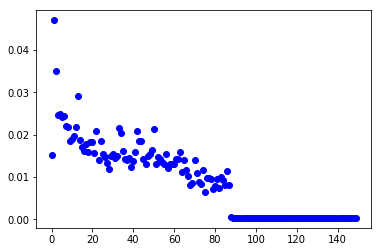

In [14]:
# We're supposed to see now a clear boundary between meaningful and meaningless topics

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

s = selection[selection.columns[1]]

plt.plot(s,'bo')

In [15]:
#Throw away meaningless topics

topic_selection = list(selection[(selection.weight > 0.005)]['topic_id'])

filtered_topic_vectors = []

for text in topic_vectors:
    new_vector = []
    for topic in topic_selection:
        new_vector.append(text[topic])
    filtered_topic_vectors.append(new_vector)

In [28]:
# Plot topic vectors as colored x,y coordinates.
# This can take a while.

from sklearn.manifold import TSNE

X = np.array(filtered_topic_vectors)
tsne_hdp = TSNE(n_components=2, random_state=0, angle=.99, init='pca').fit_transform(X)

X = np.array(filtered_topic_vectors)
tsne_color_model = TSNE(n_components=3).fit_transform(X)

In [43]:
# Translate colors to RGB space

tsne_upper_bound = [ max([x[i] for x in tsne_color_model]) for i in range(0,3) ]
tsne_lower_bound = [ min([x[i] for x in tsne_color_model]) for i in range(0,3) ]

rgb_upper_bound = 255
rgb_lower_bound = 0

colors = []
for x in tsne_color_model:
    rgb = []
    for i in range(0,3):
        tsne_bound = [tsne_lower_bound[i], tsne_upper_bound[i]]
        rgb_bound = [rgb_lower_bound, rgb_upper_bound]
        component = np.interp( x[i], tsne_bound, rgb_bound )
        rgb.append(component)
    colors.append([int(x) for x in rgb ])

In [45]:
# Save HDP-categorized corpus as JSON file

logger.info('Building json.')

def find_source(index, documents):
    doc_list = []
    for dct in documents:
        doc_list.append(len(dct['tokens']))
    doc_list = np.cumsum(doc_list)
    for idx, item in enumerate(doc_list):
        if item >= index:
            # Erase [6:-4] if you don't want the filename to be trimmed
            return documents[idx]['source'][6:-4]

entry_list = []
for idx, topic in enumerate(filtered_topic_vectors):
    entry = {}
    entry['body'] = original_texts[idx]
    entry['source'] = find_source(idx, documents)
    entry['id'] = idx
    entry['x'] = int(tsne_hdp[idx][0] * 100)
    entry['y'] = int(tsne_hdp[idx][1] * 100)
    entry['r'] = colors[idx][0]
    entry['g'] = colors[idx][1]
    entry['b'] = colors[idx][2]
    entry_list.append(entry)

open(vedabase_corpus, 'w+').close()
with open(vedabase_corpus, 'w') as f:
    json.dump(entry_list, f)
    
logger.info('Done.')

2018-11-10 08:02:36,580 - HDP-TSNE - INFO - Building json.
2018-11-10 08:02:39,282 - HDP-TSNE - INFO - Done.
